## 02-Diagnose convergence and divergence in GPML:Transform topologies


In [1]:
from diagnose_convergence import diagnose_topology_convergence

import numpy as np
import pygplates
import ptt
import gplately

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader

import os, glob
import pandas as pd

### Loading files (1): GPlately's DataServer
Plate models available: `Muller2019`, `Muller2016`, `Cao2020`, `Clennett2020`, `Seton2012`, `Matthews2016`, `Meridth2017`, `Li2008`, `Pehrsson2015`, `TorsvikCocks2017`, `Young2019`, `Scotese2008`, `Golonka2007`, `Clennett2020_M2019`, `Clennett2020_S2013`

In [2]:
# Point to Merdith 2021 from DataServer
gdownload = gplately.download.DataServer("Merdith2021")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

coastlines, continents, COBs = gdownload.get_topology_geometries()
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Merdith2021.


### Loading files (2): Pointing to filenames with glob, os
Remove """ """ to un-comment out these lines.

In [ ]:
"""
input_directory = "/Users/laurenilano/Downloads/SM2/"

# Rotation files and model
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)


# Topology feature filenames, and create a FeatureCollection
topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

static_polygons = pygplates.FeatureCollection(input_directory+"shapes_static_polygons_Merdith_et_al.gpml")
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)


time = 0 # Can be any time, and can be updated later using gplot.time = time
continent_filename = "/Users/laurenilano/Downloads/SM2 5/shapes_continents_Merdith_et_al.gpml"
gplot = gplately.plot.PlotTopologies(model, time, _, continent_filename)
"""

Run `diagnose_convergence` for transforms by specifying `boundary_feature_types = [pygplates.FeatureType.gpml_transform]`

In [3]:
def plot_ridges_and_transforms(model, gplot, time, save_directory):

    # PLATE TECTONIC TOOLS - RIDGE POINTS AND VELOCITIES ---------------------------------------------
    # Resolve MOR polylines into point data with PTT, get their latitudes and longitudes
    ridge_data = model.tesselate_mid_ocean_ridges(time, ignore_warnings=True)
    ridge_lon, ridge_lat = ridge_data[:,0], ridge_data[:,1]
    
    # Mean ridge spreading velocity + its standard deviation (in cm/year)
    ridge_vel = ridge_data[:,2]  # spreading velocities of ridge segments in cm/yr
    ridge_vel_mean = np.mean(ridge_vel) # mean global spreading velocity amongst all ridge segments in cm/yr
    ridge_vel_std = np.std(ridge_vel) # standard deviation

    # DIAGNOSING DIVERGENCE AND CONVERGENCE IN TRANSFORMS ---------------------------------------------
    transform_features, transform_vels = diagnose_topology_convergence(
        rotation_model, topology_features, time, 
        boundary_feature_types=[pygplates.FeatureType.gpml_transform]) # Specify transform feature type
    all_transform_vels = [vel for point_vel in transform_vels for vel in point_vel]
    
    lons = []
    lats = []
    for r in transform_features:
        for segment in r.get_all_geometries():
            lats.extend(segment.to_lat_lon_array()[:,0])
            lons.extend(segment.to_lat_lon_array()[:,1])
    
    # Set up plot ------------------------------------------------------------------------------------------
    fig = plt.figure(figsize=(18,14), dpi=100)
    ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 20))
    ax1.set_title("PTT topologies at {} Ma: Merdith 2021".format(time))
    
    gplot.time = time
    gplot.plot_continents(ax1, color='gainsboro')
    gplot.plot_plate_motion_vectors(ax1, spacingX=7.5, spacingY=7.5, alpha=0.3, color='k', zorder=2)

    # Plot the PTT MOR points ------------------------------------------------------------------------------
    ridges = ax1.scatter(ridge_lon, ridge_lat, c=ridge_vel, vmin=0, vmax=20, cmap="YlGn", s=50, transform=ccrs.PlateCarree(), label="PTT ridges")
    plt.colorbar(ridges, shrink=0.3, label="Spreading rate (cm/yr)")
    
    # Plot all transforms using a diverging colormap ---------------------------------------------
    transforms = ax1.scatter(lons, lats, transform=ccrs.PlateCarree(), 
                             c=all_transform_vels, cmap='seismic', vmax=20, vmin=-20,
                            label="gpml:Transform features")
    plt.colorbar(transforms, shrink=0.3, label="gpml:Transforms rate (cm/yr)")
    ax1.legend(loc="lower left", bbox_to_anchor=(-0.1,-0.1))

    # Plate boundary outlines: -------------------------------------------------------------------
    # Identify all unique plate IDs belonging to each topology at this timestep
    plate_ids = []
    for feature in gplot.topologies:
        plate_ids.append(feature.get_reconstruction_plate_id())
    unique_plate_ids = np.unique(plate_ids)
    
    for plate_id in unique_plate_ids:
        gplot.plot_plate_id(ax1, plate_id, facecolor=(0, 1, 0, 0), edgecolor="k")
        
    # Set up global extent, and save to output
    ax1.set_global()
    plt.savefig(save_directory+"/ptt_ridges_and_transforms_{}_Ma.png".format(int(time)))
    
    # plt.close() #(TOGGLE THIS TO MINIMISE PLOT OUTPUTS!!!)
    
    print("Image for {} Ma done!".format(time))
    return

/Users/laurenilano/opt/miniconda3/envs/gplateely/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


Image for 500 Ma done!


/Users/laurenilano/opt/miniconda3/envs/gplateely/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


Image for 499 Ma done!


/Users/laurenilano/opt/miniconda3/envs/gplateely/lib/python3.8/site-packages/cartopy/crs.py:529: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


Image for 498 Ma done!


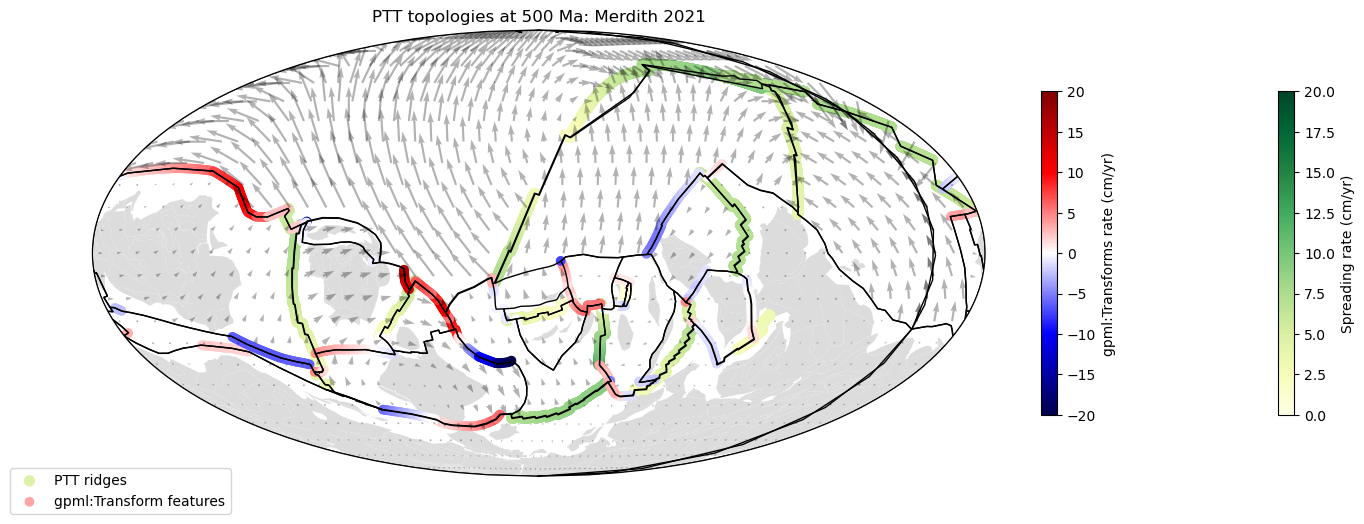

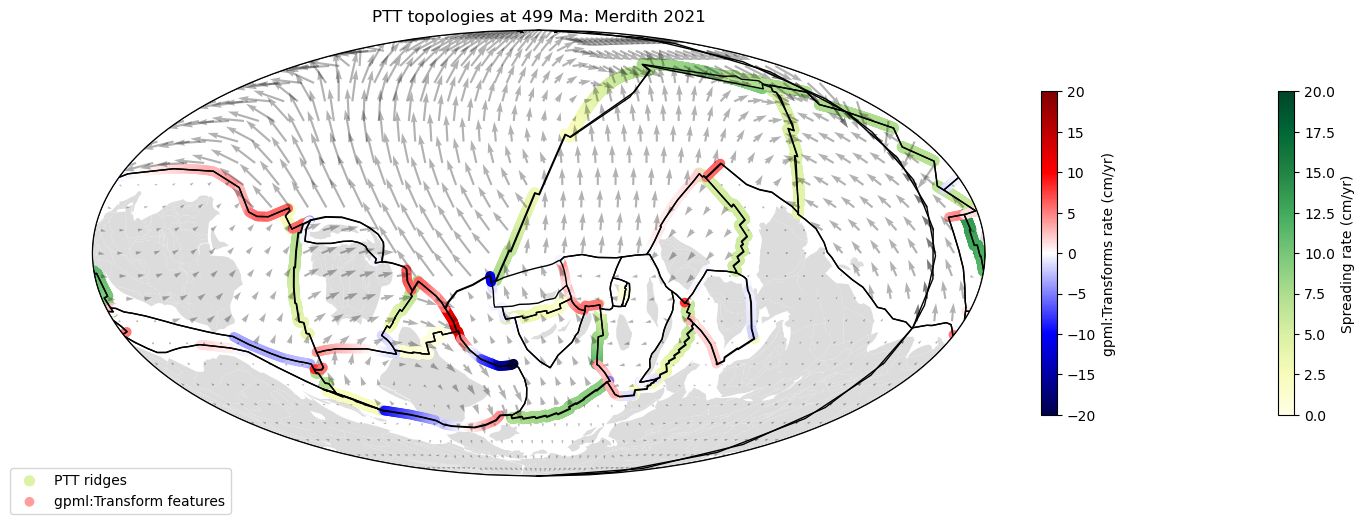

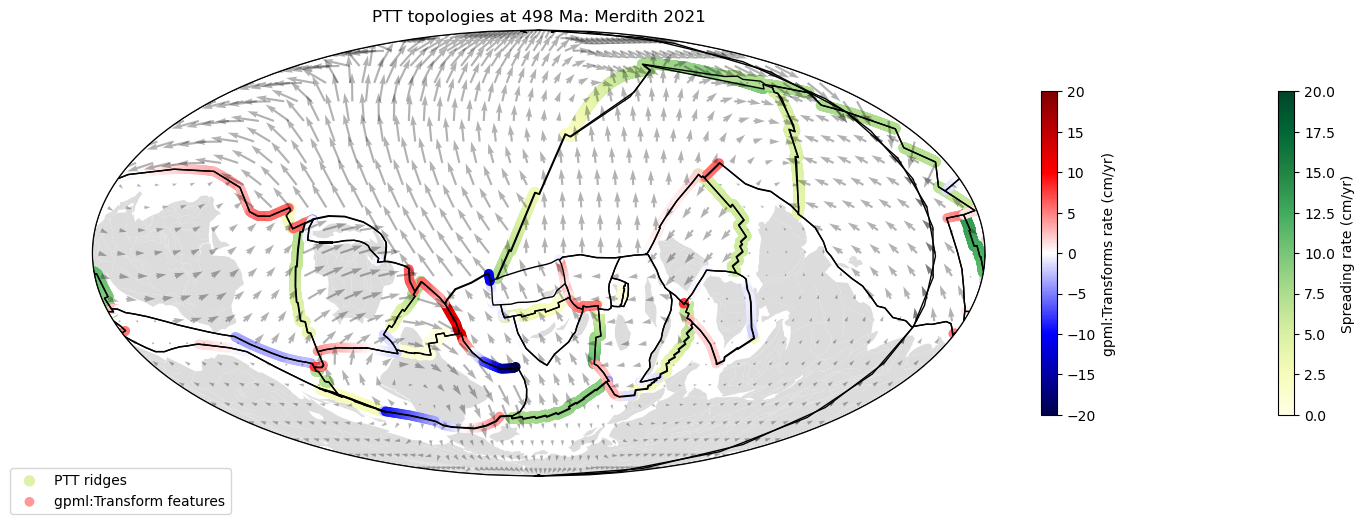

In [4]:
# Time variables
max_time = 500 # Ma
min_time = 498 # Ma
time_step = 1 # Ma
reconstruction_times = np.arange(min_time, max_time+time_step, time_step)[::-1]

save_directory = "./OutputFigures"
for time in reconstruction_times:
    plot_ridges_and_transforms(model, gplot, time, save_directory)

### Run this cell to make a movie and save to MP4

In [ ]:
import moviepy.editor as mpy
import numpy as np

frame_list = []

for time in np.arange(min_time, max_time+time_step, time_step)[::-1]:
    frame_list.append(save_directory+"/ptt_ridges_and_transforms_{}_Ma.png".format(int(time)))
    
clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif(save_directory+"/ptt_ridges_and_transforms.gif")

from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open(save_directory+"/ptt_ridges_and_transforms.gif",'rb') as f:
    display(Image(data=f.read(), format='png', width = 2000, height = 500))

In [ ]:
clip = mpy.VideoFileClip(save_directory+"/ridges_trenches_gif.gif")
clip.write_videofile(save_directory+"/ridges_trenches.mp4")